# Import Libraries & Data

In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


# Load Dataset
df = pd.read_csv('/kaggle/input/us-tariffs-2025/Tariff Calculations plus Population.csv', delimiter=';', thousands=',')
df.head()

,Country,US 2024 Deficit,US 2024 Exports,US 2024 Imports (Customs Basis),Trump Tariffs Alleged,Trump Response,Population
0,Afghanistan,-11.1,11.4,22.6,49%,25%,41454761.0
1,Albania,13.4,141.7,128.3,10%,10%,2745972.0
2,Algeria,-1447.1,1014.5,2461.6,59%,29%,46164219.0
3,Andorra,1.5,4.9,3.4,10%,10%,80856.0
4,Angola,-1186.9,682.4,1869.2,63%,32%,36749906.0


# Check Data Types and Column Names

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          204 non-null    object 
 1   US 2024 Deficit                  204 non-null    float64
 2   US 2024 Exports                  204 non-null    float64
 3   US 2024 Imports (Customs Basis)  204 non-null    float64
 4   Trump Tariffs Alleged            204 non-null    object 
 5   Trump Response                   204 non-null    object 
 6   Population                       172 non-null    float64
dtypes: float64(4), object(3)
memory usage: 11.3+ KB


# Check for Missing Values

In [16]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 Country                             0
US 2024 Deficit                     0
US 2024 Exports                     0
US 2024 Imports (Customs Basis)     0
Trump Tariffs Alleged               0
Trump Response                      0
Population                         32
dtype: int64


# Check for Numeric Format Issues

In [17]:
# Inspect columns to ensure numeric columns have no formatting issues (like commas, percentages)
for col in ['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Trump Tariffs Alleged', 'Trump Response', 'Population']:
    print(f"\nColumn '{col}' unique values:\n", df[col].unique()[:10])  # shows first 10 unique values



Column 'US 2024 Deficit' unique values:
 [-1.1100e+01  1.3400e+01 -1.4471e+03  1.5000e+00 -1.1869e+03  7.1300e+01
  5.5000e+02  2.0788e+03  3.9200e+01  7.1480e+02]

Column 'US 2024 Exports' unique values:
 [1.1400e+01 1.4170e+02 1.0145e+03 4.9000e+00 6.8240e+02 7.2500e+01
 5.7380e+02 9.1710e+03 1.6080e+02 7.2550e+02]

Column 'US 2024 Imports (Customs Basis)' unique values:
 [2.2600e+01 1.2830e+02 2.4616e+03 3.4000e+00 1.8692e+03 1.2000e+00
 2.3800e+01 7.0922e+03 1.2160e+02 1.0700e+01]

Column 'Trump Tariffs Alleged' unique values:
 ['49%' '10%' '59%' '63%' '74%' '47%' '20%' '70%' '88%' '97%']

Column 'Trump Response' unique values:
 ['25%' '10%' '29%' '32%' '37%' '24%' '35%' '23%' '44%' '49%']

Column 'Population' unique values:
 [41454761.  2745972. 46164219.    80856. 36749906.       nan    93316.
 45538401.  2990900.   107359.]


# Check for duplicate rows

In [18]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)


Number of duplicate rows: 0


# Quick descriptive statistics to spot unusual values

In [19]:
# Quick descriptive statistics to spot unusual values
df.describe(include='all')


,Country,US 2024 Deficit,US 2024 Exports,US 2024 Imports (Customs Basis),Trump Tariffs Alleged,Trump Response,Population
count,204,204.000000,204.000000,204.000000,204,204,1.720000e+02
unique,204,NaN,NaN,NaN,52,37,NaN
top,Zimbabwe,NaN,NaN,NaN,10%,10%,NaN
freq,1,NaN,NaN,NaN,130,141,NaN
mean,NaN,-5884.929902,10139.176471,16031.058333,NaN,NaN,4.286567e+07
std,NaN,31981.610534,44538.644239,71428.718556,NaN,NaN,1.602899e+08
min,NaN,-295401.600000,0.600000,0.100000,NaN,NaN,9.816000e+03
25%,NaN,-117.550000,59.175000,15.200000,NaN,NaN,8.149932e+05
50%,NaN,30.400000,227.500000,186.550000,NaN,NaN,6.833880e+06
75%,NaN,194.300000,1973.425000,2006.475000,NaN,NaN,2.831881e+07


# Quick Visual Check for Outliers

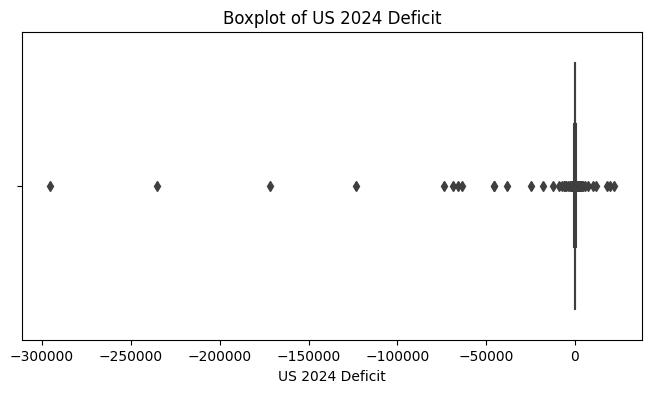

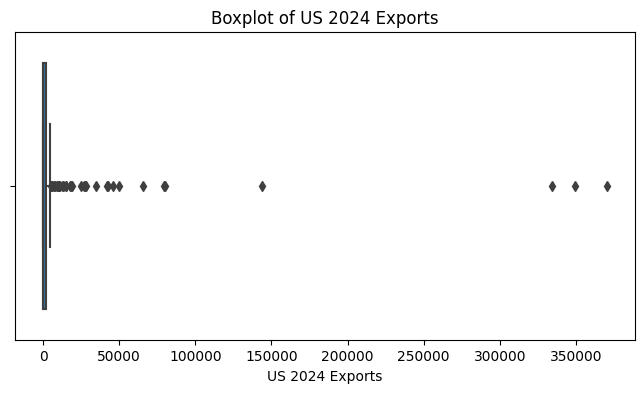

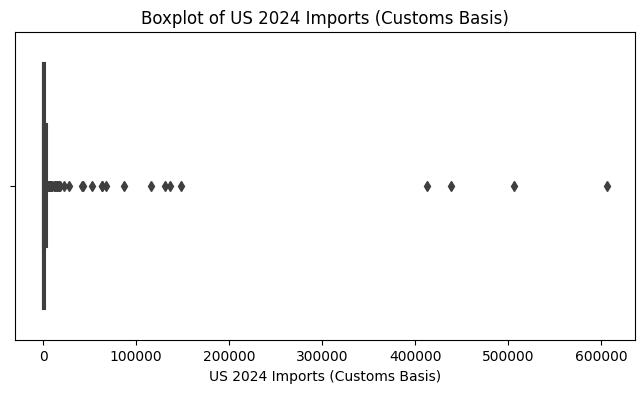

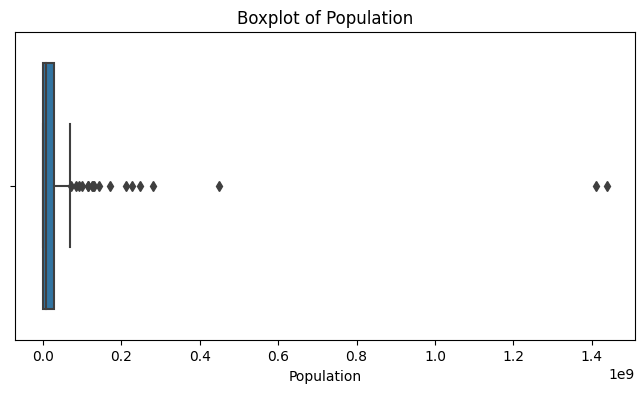

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visual inspection for outliers in numeric columns
numeric_cols = ['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Population']

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col].astype(str).str.replace(',', '').astype(float))
    plt.title(f'Boxplot of {col}')
    plt.show()


# Fix Missing Values, Numeric Formatting Issues, Outliers
# Genuine outliers such as China/India for population but i am going to use median for this project

In [21]:
# Fill missing population with median
df['Population'].fillna(df['Population'].median(), inplace=True)

# Clean percentage columns and convert to numeric
df['Trump Tariffs Alleged'] = df['Trump Tariffs Alleged'].str.rstrip('%').astype(float)
df['Trump Response'] = df['Trump Response'].str.rstrip('%').astype(float)

# Remove commas from numeric columns explicitly
cols_to_clean = ['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Confirm missing values and data types fixes

In [22]:
# Check again for missing values and data types
df.info()
df.isnull().sum()

# Ensure no duplicates
assert df.duplicated().sum() == 0, "Duplicates found!"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          204 non-null    object 
 1   US 2024 Deficit                  204 non-null    float64
 2   US 2024 Exports                  204 non-null    float64
 3   US 2024 Imports (Customs Basis)  204 non-null    float64
 4   Trump Tariffs Alleged            204 non-null    float64
 5   Trump Response                   204 non-null    float64
 6   Population                       204 non-null    float64
dtypes: float64(6), object(1)
memory usage: 11.3+ KB


# EDA & Visualization

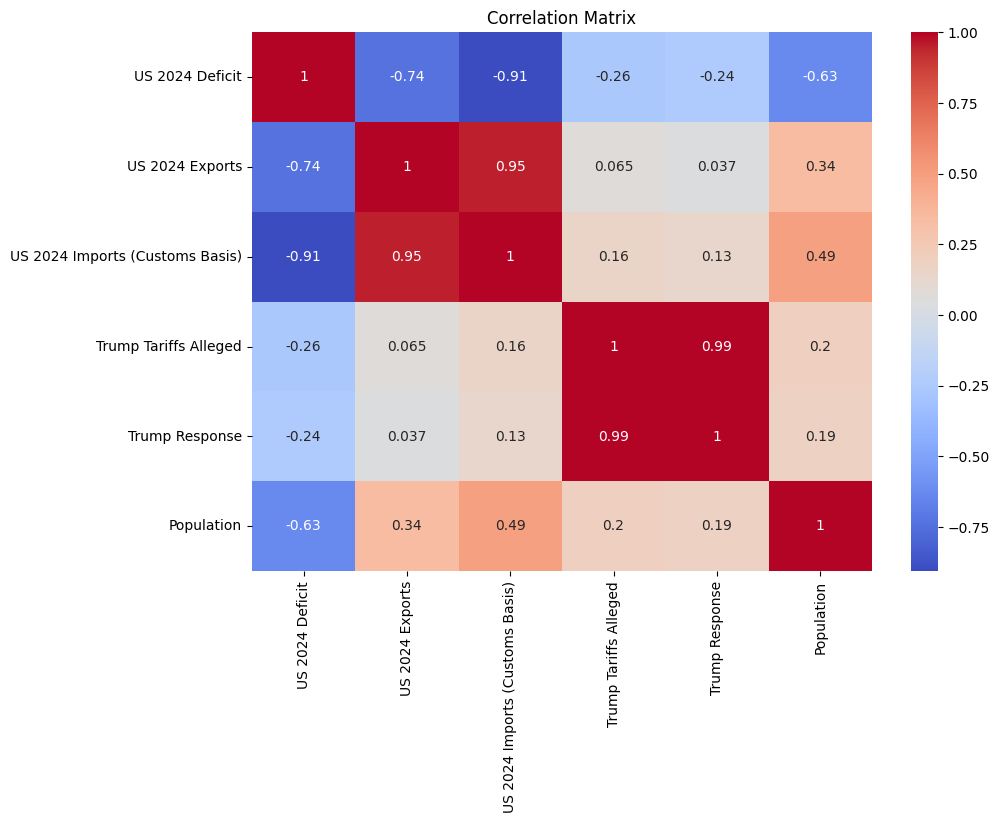

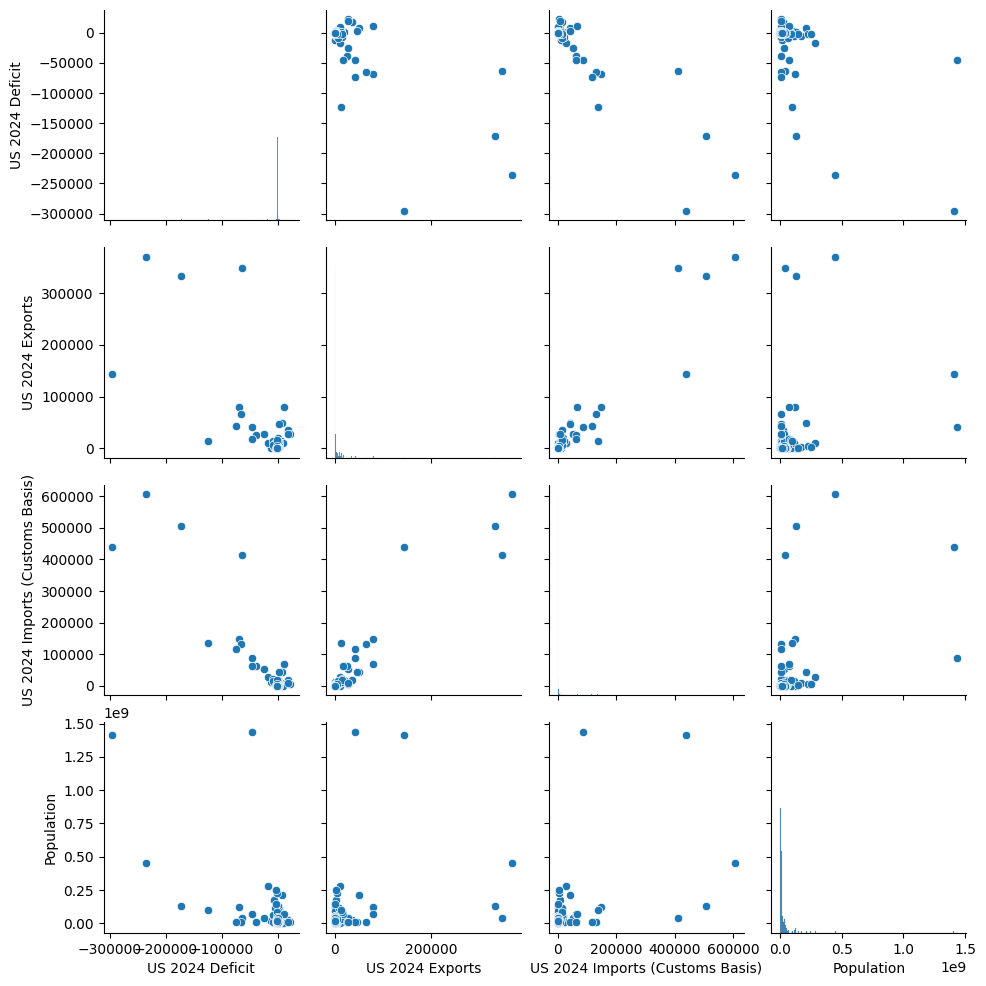

In [23]:
# Correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplots
sns.pairplot(df[['US 2024 Deficit', 'US 2024 Exports', 'US 2024 Imports (Customs Basis)', 'Population']])
plt.show()


# Multicollinearity:

# High correlation between Exports and Imports, and between Trump Tariffs Alleged and Trump Response can cause issues in predictive models.

# Advanced Analysis (Feature Engineering) [Refactored to handle multicollinearity]

In [24]:
# Tariff difference (highly correlated, replace original two columns)
df['Tariff Difference'] = df['Trump Tariffs Alleged'] - df['Trump Response']

# Trade Balance Ratio ( to handle multicollinearity)
df['Trade Balance Ratio'] = df['US 2024 Exports'] / df['US 2024 Imports (Customs Basis)']

# Per capita metrics
df['Imports per Capita'] = (df['US 2024 Imports (Customs Basis)'] * 1e6) / df['Population']
df['Exports per Capita'] = (df['US 2024 Exports'] * 1e6) / df['Population']

# Data Splitting & Scaling (Adjusted features)

In [25]:
# Eliminating highly correlated features
X = df[['Trade Balance Ratio', 'Tariff Difference', 'Imports per Capita', 'Exports per Capita', 'Population']]
y = df['US 2024 Deficit']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Model Training & Cross-validation

In [26]:
# Model setup
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# Cross-validation
model_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    model_scores[name] = scores.mean()
    print(f"{name}: Avg R² = {scores.mean():.4f}")


LinearRegression: Avg R² = -0.3984
Ridge: Avg R² = -0.2539
Lasso: Avg R² = -0.3947
RandomForest: Avg R² = 0.1911
GradientBoosting: Avg R² = 0.3581


# Evaluation of Multiple Models

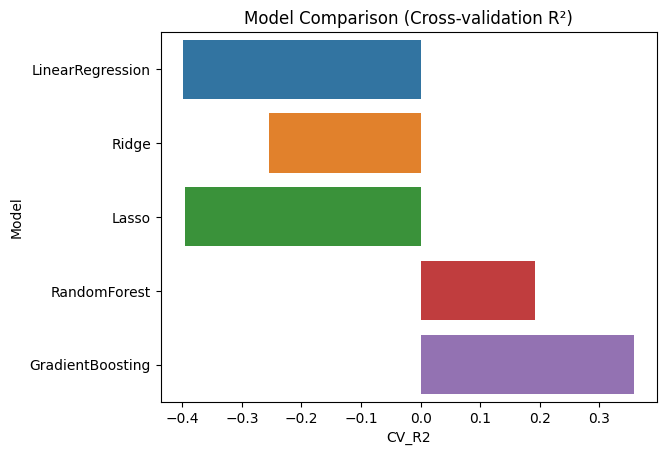

In [27]:
# Visual comparison
scores_df = pd.DataFrame(model_scores.items(), columns=['Model', 'CV_R2'])
sns.barplot(data=scores_df, x='CV_R2', y='Model')
plt.title('Model Comparison (Cross-validation R²)')
plt.show()


# Selection of Best Model & Further Evaluation
# Selection of Gradient Boosting Model & Further Evaluation
# Train Gradient Boosting on the full training set

In [28]:
# Import
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = gb_model.predict(X_test_scaled)

# Evaluation metrics
print(f"Gradient Boosting Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Gradient Boosting Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Gradient Boosting Test R²: {r2_score(y_test, y_pred):.2f}")


Gradient Boosting Test MAE: 8140.85
Gradient Boosting Test RMSE: 33056.92
Gradient Boosting Test R²: -1.45


# Feature Importance Visualization

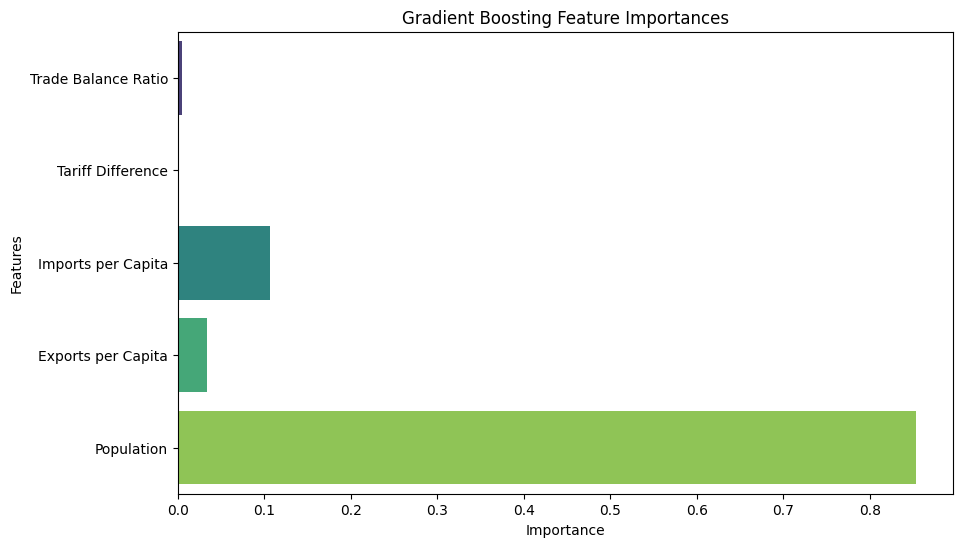

In [29]:
# Feature Importance Plot
importances = gb_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


# Hyperparameter Optimization (Gradient Boosting)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Defining parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Grid Search with cross-validation
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search_gb.fit(X_train_scaled, y_train)

# Best hyperparameters and R² score
print("🎯 Best hyperparameters:", grid_search_gb.best_params_)
print("🏆 Best cross-validation R²:", grid_search_gb.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


# Train the Optimized Model

In [ ]:
# Final optimized Gradient Boosting model
optimized_gb = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=2,
    n_estimators=200,
    subsample=1.0,
    random_state=42
)

optimized_gb.fit(X_train_scaled, y_train)

# Evaluate on the Test Set

In [ ]:
# Predictions
final_predictions = optimized_gb.predict(X_test_scaled)

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
r2 = r2_score(y_test, final_predictions)

print(f"🚀 Optimized Gradient Boosting Test MAE: {mae:.2f}")
print(f"🚀 Optimized Gradient Boosting Test RMSE: {rmse:.2f}")
print(f"🚀 Optimized Gradient Boosting Test R²: {r2:.2f}")

# Optimized Gradient Boosting Model Visualization

In [ ]:
# Visualizing final model feature importances
importances = optimized_gb.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="Blues_d")
plt.title('Optimized Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


# Save Final Optimized Model and Scaler

In [ ]:
import joblib

# Save final model and scaler for deployment
joblib.dump(optimized_gb, 'optimized_gradient_boosting_model.pkl')
joblib.dump(scaler, 'final_scaler.pkl')

# 🛠️ Finalized Workflow

---

## **Data Preparation and Validation**
- **Import Libraries & Data**
- **Check Data Types and Column Names**
- **Check for Missing Values**
- **Check for Numeric Format Issues**
- **Check for Duplicate Rows**
- **Quick Descriptive Statistics (Identify unusual values)**
- **Quick Visual Check for Outliers**

---

## **Data Cleaning**
- **Fix Missing Values, Duplicates, Numeric Formatting Issues, Outliers, and Unusual Values**
- **Confirm Fixes**

---

## **Exploratory Data Analysis (EDA)**
- **EDA & Visualization**
  - Correlation analysis
  - Distribution analysis
  - Multicollinearity assessment

---

## **Feature Engineering**
- **Advanced Analysis (Feature Engineering)**
  - Derived meaningful features
  - Refactored features based on EDA insights
- **Adjusted Features** *(Address Multicollinearity and Redundancy)*

---

## **Modeling & Evaluation**
- **Model Training & Cross-validation (Multiple Models)**
- **Evaluation of Multiple Models**
- **Selection of Best Model & Further Evaluation**
- **Feature Importance Visualization**

---

## **Model Optimization and Finalization**
- **Model Optimization / Hyperparameter Tuning**
  - Optimized using GridSearchCV *(Gradient Boosting)*
- **Train the Optimized Model**
- **Evaluate on the Test Set**
- **Optimized Model Visualization**
  - Feature importance for the optimized model

---

## **Deployment Preparation**
- **Save Final Optimized Model and Scaler**

---